### Forecast Data

| Property            | Type              | Description                                       |
|---------------------|------------------|---------------------------------------------------|
| id | String | Session object ID. |
| startTimestamp | Integer  | Unix timestamp, session start timestamp. |
| waveCount | Integer  | Number of waves caught in the session, defaults to 0 |
| speedMax | Float  | Max speed attained in wave, will be null if no waves surfed. |
| distancePaddled | Float  | Total distance paddled. Can be null if the user hasn't paddled anywhere or the device doesn't provide this.|
| distanceWaves | Float  | Total distance surfed (sum of all wave distances). Null if no waves surfed.|
| calories | Integer  | Calories burned whilst surfing. Can be null if device doesn't provide this.|
| wavesPerHour | Integer  |Average waves caught per hour surfed. Can be null if no waves caught.|
| ratings | Integer | Automated rating for the Sessions time.  0 = VERY POOR, 1 = POOR, 2 = POOR TO FAIR, 3 = FAIR, 4 = FAIR TO GOOD |
| user | String | Unique user ID. |
| tide	| Float | Tide level in *feet*. |
| tide_normalized| Float | Normalized tide level. 0 = lowest tide possible, 1 = highest tide possible. |	
| next_tide| String | Next tide event, describing the tide level, type of extrema, and time of the extrema. |
| minBWH	| Float | Minimum breaking wave height in *feet*. |
| maxBWH| Float | Maximum breaking wave height in *feet*. |
| hour	| Integer |  1 = 1am, 2 = 2am, 13 = 1pm, etc. |
| month	| Integer |  1 = January, 2 = February, etc. |
| weekday| Integer |  0 = Monday, 1 = Tuesday, etc. |

---

### Event

All events are stored in `waves/{SESSIONID}.json`. Each file contains an array of Event objects.


#### Object Properties

| Parameter      | Type    | Description                                                                                      |
| -------------- | ------- | ------------------------------------------------------------------------------------------------ |
| startTimestamp | Integer      | UTC timestamp when the event started.                                                            |
| endTimestamp   | Integer       | UTC timestamp when the event ended.                                                              |
| type           | Enum         | Key to detonate the event type: `PADDLE` - Used when the user is paddling. `WAVE` - Used when the user is actively surfing a wave.                                                                 |
| outcome        | Enum        | Key to detonate the outcome for this event: `ATTEMPTED` - This wave event was attempted only. `CAUGHT` - This wave event was considered as having been caught. (default is `CAUGHT`)         |
| distance   | Float      | Distance of the wave event in *meters*.                                                              |
| speedMax       | Float        | Maximum speed the user traveled during this event in *meters per second*.                        |
| speedAverage   | Float         | Average speed the user traveled during this event in *meters per second*.                        |
| positions      | Array         | Array of Position objects that are included as part of this event.   |

---

### Position

Object used to describe a discrete position in a user's session.

#### Object Properties

| Parameter      | Type    | Description                                                                                      |
| -------------- | -------  | ------------------------------------------------------------------------------------------------ |
| timestamp      | Integer    | Unix timestamp in milliseconds when this position object occurred.                               |
| latitude       | Float        | Coorindate latitude, degrees, decimal format.                                                    |
| longitude      | Float       | Coorindate longitude, degrees, decimal format.                                                   |
| location |    Object    | Object containing the location info for the position. |
| location.type | String  | The type of spot location (Eg: POINT). |
| location.coordinates | Array | Coordinate array ([lon, lat]) |

In [52]:
import pandas as pd
import json
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import matplotlib.pyplot as plt

In [3]:
forecast = pd.read_csv("BanthamForecast.csv")

## Data Format

A **user** (in the forecast data), has a **session** (id in forecast data and json filename), which has multiple **events** (waves, and paddling, with different outcomes). Each event has it's own event id, which is separate from the session or user id. Each session file belongs to only one user, for only one session. Some users have multiple sessions in this data (up to 185).

In [74]:
sessions = {}
for session_id in forecast._id:
    with open(f"waves/{session_id}.json") as f:
        session = json.load(f)
    sessions[session_id] = session

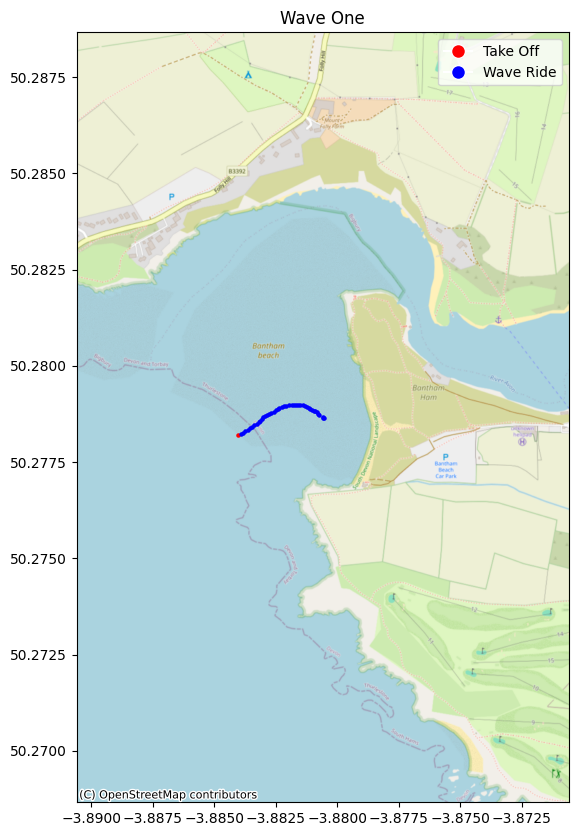

In [67]:
f, ax = plt.subplots(figsize=(10, 10))
counter = 1
for position in session[0]["positions"]:
    lat = position["location"]["coordinates"][1]
    lon = position["location"]["coordinates"][0]
    point_geom = Point(lon, lat)
    point_gdf = gpd.GeoDataFrame(geometry=[point_geom], crs="EPSG:4326")
    if counter == 1:
        point_gdf.plot(ax=ax, markersize=5, color="red")
    else:
        point_gdf.plot(ax=ax, markersize=5, color="blue")
    counter -= 1
padding = 0.01
ax.set_xlim(lon - padding, lon + padding)
ax.set_ylim(lat - padding, lat + padding)
ax.set_title("Wave One")
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Take Off', markerfacecolor='red', markersize=10)
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Wave Ride', markerfacecolor='blue', markersize=10)
ax.legend(handles=[red_patch, blue_patch])
ctx.add_basemap(ax, crs=point_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

## Next Task

- Plot every wave's take off position (first position in wave event)
- Color it based on the tide information in the forecast df? Or by the date, to see shifting sandbanks?

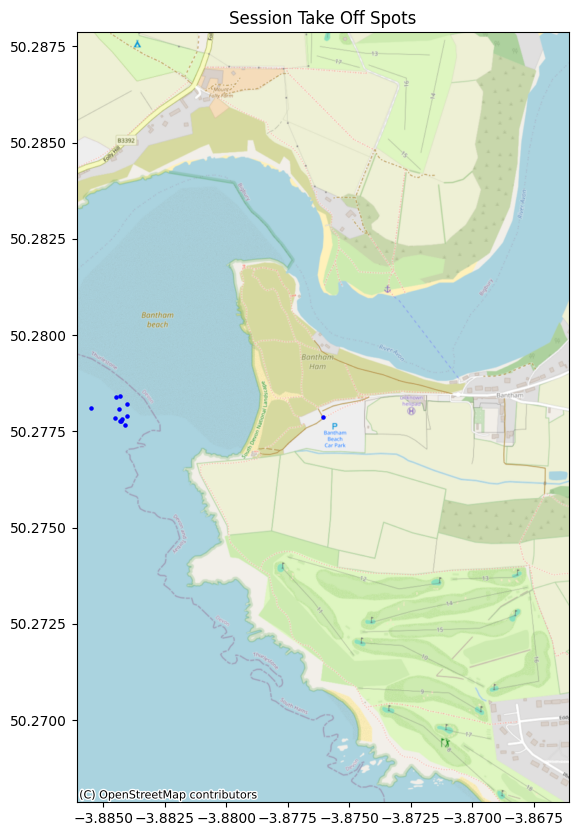

In [75]:
f, ax = plt.subplots(figsize=(10, 10))
for wave_event in session:
    take_off = wave_event["positions"][0]
    lat = take_off["location"]["coordinates"][1]
    lon = take_off["location"]["coordinates"][0]
    point_geom = Point(lon, lat)
    point_gdf = gpd.GeoDataFrame(geometry=[point_geom], crs="EPSG:4326")
    point_gdf.plot(ax=ax, markersize=5, color="blue")
padding = 0.01
ax.set_xlim(lon - padding, lon + padding)
ax.set_ylim(lat - padding, lat + padding)
ax.set_title("Session Take Off Spots")
ctx.add_basemap(ax, crs=point_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

In [88]:
wave_event["type"]

'WAVE'

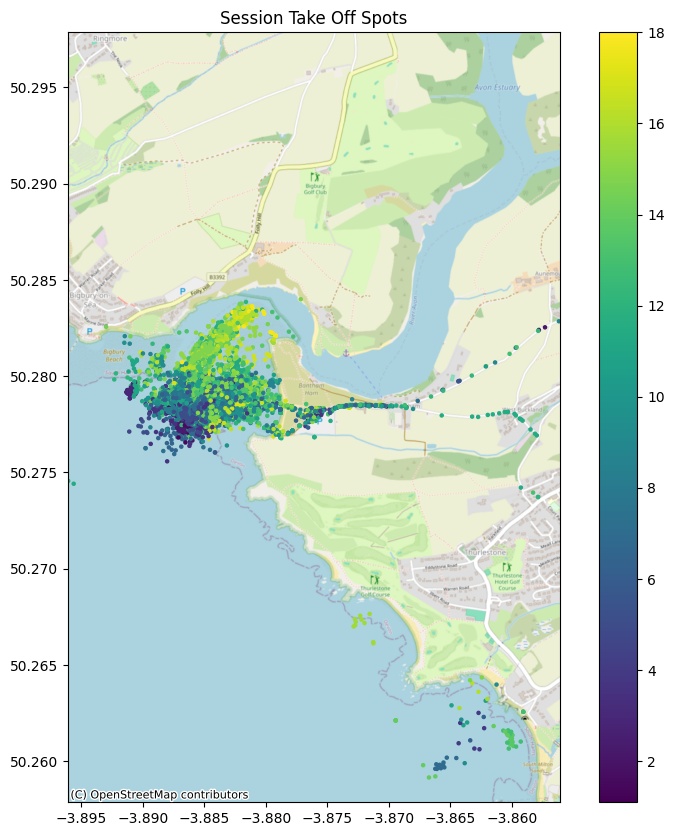

In [89]:
plotting_df = gpd.GeoDataFrame()
# sample_sessions = dict(list(sessions.items())[:5])
for session_id, session in sessions.items():
    for wave_event in session:
        if wave_event["type"] == "WAVE":
            take_off = wave_event["positions"][0]
            lat = take_off["location"]["coordinates"][1]
            lon = take_off["location"]["coordinates"][0]
            point_geom = Point(lon, lat)
            tide = forecast[forecast._id == session_id]["tide_ft"].values[0]
            point_gdf = gpd.GeoDataFrame(geometry=[point_geom], crs="EPSG:4326")
            point_gdf["tide"] = tide
            plotting_df = pd.concat([plotting_df, point_gdf], ignore_index=True)

f, ax = plt.subplots(figsize=(10, 10))
plotting_df.plot(ax=ax, markersize=5, column="tide", cmap="viridis", legend=True)
padding = 0.02
ax.set_xlim(lon - padding, lon + padding)
ax.set_ylim(lat - padding, lat + padding)
ax.set_title("Session Take Off Spots")
ctx.add_basemap(ax, crs=plotting_df.crs, source=ctx.providers.OpenStreetMap.Mapnik)

In [77]:
forecast

,_id,waveCount,speedMax,distancePaddled,distanceWaves,distanceLongestWave,user,startTimestamp_UNIX,tide_ft,tide_normalized,next_tide,ratings,minBWH_ft,maxBWH_ft,month,hour,weekday,hour.1
0,5fbe9bee1d3e272efd9957cf,19,4.555556,5692.89,595.10,62.91,56faecae19b74318a73d9339,1.570864e+09,12.8,0.62,4.7_low_at_11:58,2.0,4.002576,6.266328,10.0,8.0,5.0,8.0
1,5fbe9a4a5fc3dac5997ca90d,20,5.613889,5520.12,1054.51,118.00,56faecae19b74318a73d9339,1.571059e+09,4.5,0.22,16.5_high_at_18:56,2.0,2.723064,4.232232,10.0,14.0,0.0,14.0
2,602a7ca6e5b48de0fa9996d5,9,5.308333,4982.70,401.11,91.70,5d4dc124443be6008da4da61,1.571060e+09,7.5,0.37,16.5_high_at_18:56,2.0,2.723064,4.232232,10.0,15.0,0.0,15.0
3,5fbe9c5a4e2c30e0777b8a2c,12,5.555556,4410.09,533.31,79.91,56faecae19b74318a73d9339,1.571130e+09,12.1,0.59,2.8_low_at_13:27,2.0,2.887104,4.527504,10.0,10.0,1.0,10.0
4,602a7c9f5a57c509d3d2c102,4,4.947222,1772.88,177.40,84.00,5d4dc124443be6008da4da61,1.571914e+09,10.3,0.50,15.0_high_at_15:24,1.0,1.902864,2.952720,10.0,12.0,3.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,64178481e23159d8e54293fd,2,3.429000,0.00,162.56,136.14,6389aae70f173700129e48f6,1.679229e+09,7.1,0.35,15.3_high_at_16:30,2.0,2.919912,4.593120,3.0,12.0,6.0,12.0
733,6418a20407eba084f27e5556,1,5.729000,0.00,18.27,18.27,56fae7fc19b74318a73b18b1,1.679319e+09,10.6,0.52,16.3_high_at_17:17,1.0,2.788680,4.363464,3.0,14.0,0.0,14.0
734,6419e61bc04a3c2b0dbe046d,1,21.921000,0.00,240.39,240.39,56fae7fc19b74318a73b18b1,1.679385e+09,12.9,0.63,1.6_low_at_11:32,1.0,4.297848,6.725640,3.0,8.0,1.0,8.0
735,6421dfd2fa589e76d656c765,13,15.410000,0.00,1418.03,398.81,56fae7fc19b74318a73b18b1,1.679843e+09,3.6,0.18,15.8_high_at_21:32,2.0,5.577360,8.726928,3.0,16.0,6.0,16.0


In [76]:
session

[{'startTimestamp': '2023-03-27T08:34:05.000Z',
  'endTimestamp': '2023-03-27T08:34:54.003Z',
  'type': 'WAVE',
  'distance': 278.51,
  'speedAverage': 6,
  'speedMax': 8.59,
  'positions': [{'timestamp': '2023-03-27T08:34:05.000Z',
    'location': {'type': 'Point',
     'coordinates': [-3.884027749300003, 50.278203785419464]}},
   {'timestamp': '2023-03-27T08:34:06.000Z',
    'location': {'type': 'Point',
     'coordinates': [-3.883924735710025, 50.27822943404317]}},
   {'timestamp': '2023-03-27T08:34:07.000Z',
    'location': {'type': 'Point',
     'coordinates': [-3.8838267512619495, 50.27826765552163]}},
   {'timestamp': '2023-03-27T08:34:08.000Z',
    'location': {'type': 'Point',
     'coordinates': [-3.883727928623557, 50.278298165649176]}},
   {'timestamp': '2023-03-27T08:34:09.000Z',
    'location': {'type': 'Point',
     'coordinates': [-3.8836306147277355, 50.27832708321512]}},
   {'timestamp': '2023-03-27T08:34:10.000Z',
    'location': {'type': 'Point',
     'coordinates':

In [40]:
wave[3]["outcome"]

'CAUGHT'

In [19]:
waves[0][0]["_id"]

'5fbe9bee1d3e272b729957bb'

In [43]:
forecast.groupby("user").size()

user
56fae7fc19b74318a73b18b1    185
56faecae19b74318a73d9339     51
571028632c02c0403920ce34      1
5740568d6c99c8e5453c333a      3
57512f6136ddd7196d690ee0     63
577c33b2511df4603adc193f      8
57888ffe2f2dd2e572b29def      1
57cba4805e9369bb60a702a8      3
582df8013719c0d73e71b890      2
5841d6caa8585ee7429e2ce5     20
5855c2b1c38bc46405878b07     13
5946b95b9db50b326f6d39e2      3
59a1ec20b96d9e3a57135f60      1
5b48ed1e69bc1e0011d7e4e2      1
5ba723ec6a8169000f62a730     10
5c46b394a4ed4e00111ddb0b      1
5c94c4b4a46ce9008d40032d      3
5ceaf6e129c6c7008d025c20      1
5d3c793cf394b8008dfc3295      1
5d4dc124443be6008da4da61     58
5dff24358494b2008ea4cccb     28
5eeb6562d0214b0090862794      3
5ef6ef71b4d0a4008f659fd7      1
5f03612edb4627008f0bd018      6
5f51dbbffb79c3008e4f6c52      2
5f6062743a10f1008e447975      2
5f928cde527cbe008e342190      1
5fbd26cbb5d084008e9304c3      1
5fe8a1950966780012ddbb20     48
5fe9b6596f88d10012bbba80      1
5fecb2bcbb82f10012886512      2
603

In [18]:
waves[0]

[{'startTimestamp': '2019-10-12T07:11:49.000Z',
  'endTimestamp': '2019-10-12T07:33:18.000Z',
  'type': 'PADDLE',
  'distance': 901.85,
  'speedMax': 3.4916666666666667,
  'speedAverage': 0.7027777777777777,
  'positions': [{'timestamp': '2019-10-12T07:11:49.000Z',
    'location': {'type': 'Point', 'coordinates': [-3.889956, 50.28088]}},
   {'timestamp': '2019-10-12T07:11:50.000Z',
    'location': {'type': 'Point', 'coordinates': [-3.889958, 50.28088]}},
   {'timestamp': '2019-10-12T07:11:51.000Z',
    'location': {'type': 'Point', 'coordinates': [-3.889962, 50.280883]}},
   {'timestamp': '2019-10-12T07:11:52.000Z',
    'location': {'type': 'Point', 'coordinates': [-3.889963, 50.280885]}},
   {'timestamp': '2019-10-12T07:11:53.000Z',
    'location': {'type': 'Point', 'coordinates': [-3.88996, 50.280886]}},
   {'timestamp': '2019-10-12T07:11:54.000Z',
    'location': {'type': 'Point', 'coordinates': [-3.889956, 50.280885]}},
   {'timestamp': '2019-10-12T07:11:55.000Z',
    'location': {